# Section 2: Bayesian Inference and PyMC

#### PyData London 2025 - Bayesian Time Series Analysis with PyMC

---

## Statistical Paradigms: Two Ways of Thinking

Before diving into Bayesian methods, it's crucial to understand how Bayesian thinking differs from the traditional frequentist approach.

### Frequentist Worldview

In frequentist statistics:
- **Data are random** (they vary each time we collect them)
- **Parameters are fixed** (unknown but constant values)
- We condition on parameters: $P(\text{data} | \text{parameters})$
- Inference through estimators and confidence intervals

### Bayesian Worldview  

In Bayesian statistics:
- **Data are fixed** (once observed, they don't change)
- **Parameters are random** (we use probability to express uncertainty)
- We condition on data: $P(\text{parameters} | \text{data})$
- Inference through probability distributions

This fundamental difference leads to more intuitive interpretations and natural uncertainty quantification.

---

## Bayes' Theorem: The Foundation

**Bayes' Theorem** is our single tool for learning from data:

$$\huge
\underbrace{\text{Pr}(\theta | y)}_{\textcolor{yellow}{\small \text{Posterior Probability}}}
= 
\frac{
\overbrace{\text{Pr}(y | \theta)}^{\textcolor{yellow}{\small \text{Data Likelihood}}} \cdot
\overbrace{\text{Pr}(\theta)}^{\textcolor{yellow}{\small \text{Prior Probability}}}
}{
\underbrace{\text{Pr}(y)}_{\textcolor{yellow}{\small \text{Normalizing Constant}}}
}
$$

### Breaking Down the Components

- **$P(\theta | y)$** = **Posterior**: What we learn about parameters after seeing data
- **$P(y | \theta)$** = **Likelihood**: How well different parameter values explain our data  
- **$P(\theta)$** = **Prior**: Our initial beliefs about parameters before seeing data
- **$P(y)$** = **Evidence**: Normalizing constant (often intractable)

### For Time Series Models

Applied to time series data $y_{1:T}$:

$$P(\theta | y_{1:T}) = \frac{P(y_{1:T} | \theta) P(\theta)}{P(y_{1:T})}$$

Where $\theta$ represents model parameters like:
- Trend coefficients
- Seasonal patterns  
- Autoregressive coefficients
- Variance parameters

### The Learning Process

Bayesian inference is a formal process of **updating beliefs**:

1. **Start** with prior beliefs $P(\theta)$
2. **Observe** data and compute likelihood $P(y | \theta)$
3. **Update** to posterior beliefs $P(\theta | y)$
4. **Repeat** as more data arrives

This makes Bayesian methods naturally suited for time series, where we continuously update our understanding as new observations arrive.

### Why MCMC?

For most real-world time series models, the posterior distribution cannot be computed analytically. **Markov Chain Monte Carlo (MCMC)** methods allow us to approximate the posterior by drawing samples from it.

**NUTS (No-U-Turn Sampler)** is PyMC's default MCMC algorithm:
- Automatically tunes step size and mass matrix
- Efficient exploration of high-dimensional parameter spaces
- Works well for most time series models
- Provides diagnostic information for convergence checking

## Prior Specification: Encoding Our Beliefs

One of the most important aspects of Bayesian modeling is **prior specification**. Priors encode our beliefs about parameters before seeing data.

### Types of Priors

1. **Informative priors**: Incorporate domain knowledge
   - Example: Birth rates are typically between 10-20 per 1000 people
   - Use: `pm.Normal('rate', mu=15, sigma=2)`

2. **Weakly informative priors**: Provide gentle regularization
   - Example: Standardized coefficients are usually between -3 and 3
   - Use: `pm.Normal('coef', mu=0, sigma=1)`

3. **Non-informative priors**: Let data dominate
   - Example: Uniform over a wide range
   - Use: `pm.Uniform('param', lower=-100, upper=100)`

### Prior Choice Guidelines

- **Start with weakly informative priors** - they provide stability
- **Use domain knowledge** when available
- **Check prior predictive distributions** - do they make sense?
- **Test sensitivity** - how much do results change with different priors?

In [1]:
# Import necessary libraries for Section 2
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import warnings

# Configure plotting and suppress warnings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
RANDOM_SEED = 42

print("🔧 Section 2 libraries loaded successfully!")
print("Ready to explore Bayesian inference with PyMC")

🔧 Section 2 libraries loaded successfully!
Ready to explore Bayesian inference with PyMC


In [2]:
# Load preprocessed data from Section 1
# (In practice, you would load this from a saved file or repeat the preprocessing)

# Load births data
births_data = pl.read_csv('../data/births.csv', null_values=['null', 'NA', '', 'NULL'])
births_data = births_data.filter(pl.col('day').is_not_null())

# Aggregate to monthly data
monthly_births = (births_data
    .group_by(['year', 'month'])
    .agg(pl.col('births').sum())
    .sort(['year', 'month'])
)

# Focus on 1970-1990 period
births_subset = (monthly_births
    .filter((pl.col('year') >= 1970) & (pl.col('year') <= 1990))
    .with_row_index('index')
)

# Standardize the data
original_data = births_subset['births'].to_numpy()
births_standardized = (original_data - original_data.mean()) / original_data.std()

print(f"📊 Data loaded: {len(births_standardized)} observations")
print(f"   Standardized data: mean={births_standardized.mean():.3f}, std={births_standardized.std():.3f}")

📊 Data loaded: 228 observations
   Standardized data: mean=-0.000, std=1.000


Sampling: [mu, prior_pred, sigma]


🔍 **Prior Predictive Check Example**
Before fitting our model, let's check if our priors make sense...


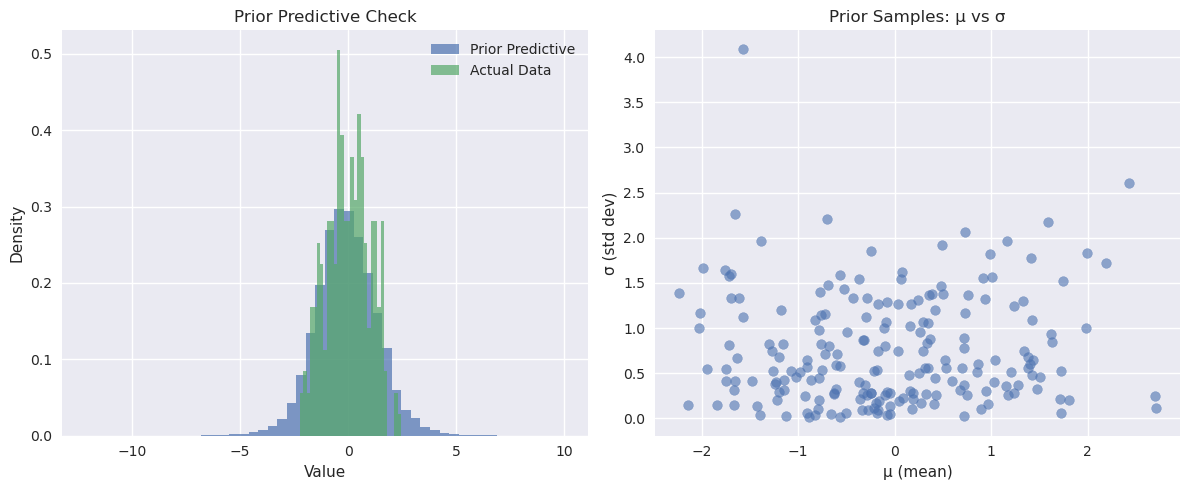


✅ **Prior Check Results**:
   • Prior predictive range: [-12.1, 10.0]
   • Actual data range: [-2.2, 2.4]
   • Our priors seem reasonable - they allow for the observed data range!


In [5]:
# Demonstration: Prior Predictive Checking
print("🔍 **Prior Predictive Check Example**")
print("="*50)
print("Before fitting our model, let's check if our priors make sense...")

# Define a model with priors only
with pm.Model() as prior_check_model:
    # Our priors for mean and std
    mu_prior = pm.Normal('mu', mu=0, sigma=1)
    sigma_prior = pm.HalfNormal('sigma', sigma=1)
    
    # What data would these priors generate?
    prior_predictive = pm.Normal('prior_pred', mu=mu_prior, sigma=sigma_prior, shape=len(births_standardized))
    
    # Sample from prior predictive
    prior_samples = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot prior predictive samples vs actual data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Prior predictive distribution
prior_pred_samples = prior_samples.prior['prior_pred'].values
ax1.hist(prior_pred_samples.flatten(), bins=50, alpha=0.7, density=True, label='Prior Predictive')
ax1.hist(births_standardized, bins=30, alpha=0.7, density=True, label='Actual Data')
ax1.set_title('Prior Predictive Check')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
ax1.legend()

# Prior distributions
mu_samples = prior_samples.prior['mu'].values.flatten()
sigma_samples = prior_samples.prior['sigma'].values.flatten()
ax2.scatter(mu_samples[:200], sigma_samples[:200], alpha=0.6)
ax2.set_xlabel('μ (mean)')
ax2.set_ylabel('σ (std dev)')
ax2.set_title('Prior Samples: μ vs σ')

plt.tight_layout()
plt.show()

print(f"\n✅ **Prior Check Results**:")
print(f"   • Prior predictive range: [{prior_pred_samples.min():.1f}, {prior_pred_samples.max():.1f}]")
print(f"   • Actual data range: [{births_standardized.min():.1f}, {births_standardized.max():.1f}]")
print(f"   • Our priors seem reasonable - they allow for the observed data range!")

## PyMC API and Workflow

PyMC provides a high-level interface for building Bayesian models. The typical workflow involves:

1. **Model Definition**: Specify priors, likelihood, and relationships
2. **Sampling**: Use MCMC to approximate the posterior
3. **Diagnostics**: Check convergence and model fit
4. **Analysis**: Summarize results and make predictions

### Simple Example: Estimating Mean and Variance

Let's start with a simple example: estimating the mean and standard deviation of our birth counts using Bayesian inference. This introduces the PyMC workflow before we dive into time series-specific models.

In [6]:
# Simple Bayesian model to estimate mean and std of the time series
print("🔬 **Demonstration: Basic PyMC Workflow**")
print("="*50)
print("Let's start with a simple example: estimating the mean and standard deviation")
print("of our birth counts using Bayesian inference.")

with pm.Model() as basic_model:
    # Prior for the mean - we expect births to be around 0 (standardized)
    mu = pm.Normal('mu', mu=0, sigma=1)
    
    # Prior for the standard deviation - positive values only
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Likelihood - our observations come from a normal distribution
    observations = pm.Normal('observations', mu=mu, sigma=sigma, observed=births_standardized)
    
    # Sample from the posterior
    trace_basic = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

# Display model summary
print("\n📊 Model Summary:")
print(az.summary(trace_basic, var_names=['mu', 'sigma']))

Initializing NUTS using jitter+adapt_diag...


🔬 **Demonstration: Basic PyMC Workflow**
Let's start with a simple example: estimating the mean and standard deviation
of our birth counts using Bayesian inference.


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



📊 Model Summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu    -0.001  0.065  -0.121    0.124      0.002    0.002    1820.0    1217.0   
sigma  1.006  0.048   0.916    1.095      0.001    0.001    1955.0    1465.0   

       r_hat  
mu       1.0  
sigma    1.0  


Sampling: [observations]


Output()

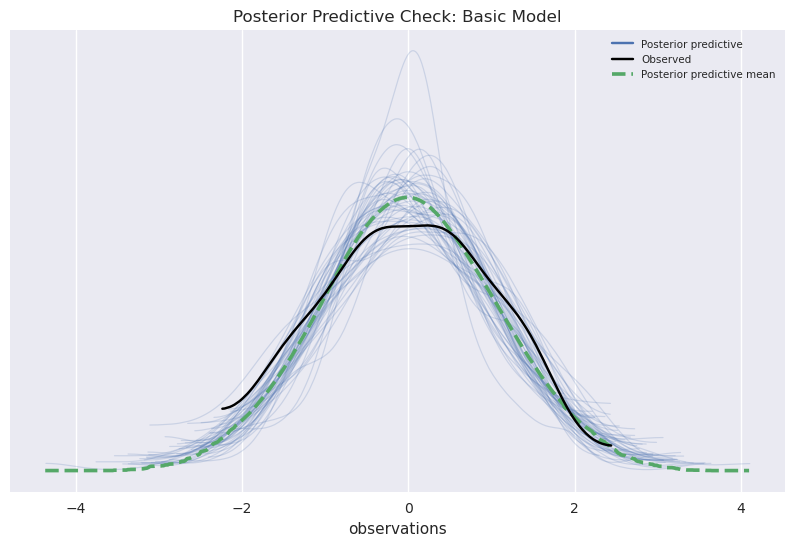


✅ **Key Insights from this Simple Model**:
   • **Posterior mean**: -0.001
   • **Posterior std**: 1.006
   • **Convergence**: R-hat values near 1.0 indicate good convergence
   • **Uncertainty**: HDI intervals quantify our uncertainty about parameters
   • **Model checking**: Posterior predictive checks assess model fit


In [7]:
# Posterior predictive checks
with basic_model:
    posterior_predictive = pm.sample_posterior_predictive(trace_basic, random_seed=RANDOM_SEED)

# Plot comparison using ArviZ
az.plot_ppc(posterior_predictive, num_pp_samples=50, figsize=(10, 6))
plt.title('Posterior Predictive Check: Basic Model')
plt.show()

print(f"\n✅ **Key Insights from this Simple Model**:")
print(f"   • **Posterior mean**: {az.summary(trace_basic, var_names=['mu'])['mean'].iloc[0]:.3f}")
print(f"   • **Posterior std**: {az.summary(trace_basic, var_names=['sigma'])['mean'].iloc[0]:.3f}")
print(f"   • **Convergence**: R-hat values near 1.0 indicate good convergence")
print(f"   • **Uncertainty**: HDI intervals quantify our uncertainty about parameters")
print(f"   • **Model checking**: Posterior predictive checks assess model fit")

## The Power of Uncertainty Quantification

One of the key advantages of Bayesian methods is that we get full probability distributions over parameters, not just point estimates. This allows us to answer probabilistic questions about our model.

In [8]:
# Show the power of Bayesian inference: uncertainty quantification
mu_samples = az.extract(trace_basic)['mu'].values
sigma_samples = az.extract(trace_basic)['sigma'].values

print(f"\n🎯 **Uncertainty Quantification Example**:")
print(f"   • Probability that true mean > 0.1: {np.mean(mu_samples > 0.1):.3f}")
print(f"   • Probability that true std < 0.9: {np.mean(sigma_samples < 0.9):.3f}")
print(f"   • 90% credible interval for mean: [{np.percentile(mu_samples, 5):.3f}, {np.percentile(mu_samples, 95):.3f}]")

print(f"\n🚀 **Next Steps**: Now that we understand the PyMC workflow, we'll build")
print(f"   more sophisticated time series models that capture temporal dependence!")


🎯 **Uncertainty Quantification Example**:
   • Probability that true mean > 0.1: 0.053
   • Probability that true std < 0.9: 0.010
   • 90% credible interval for mean: [-0.108, 0.104]

🚀 **Next Steps**: Now that we understand the PyMC workflow, we'll build
   more sophisticated time series models that capture temporal dependence!


## Model Diagnostics: Ensuring Reliable Inference

Before trusting our results, we must check that our MCMC sampling worked properly. Poor sampling can lead to incorrect conclusions.

### Key Diagnostic Metrics

1. **R-hat (Gelman-Rubin statistic)**: Measures convergence across chains
   - **Good**: R-hat ≤ 1.01
   - **Acceptable**: R-hat ≤ 1.1  
   - **Poor**: R-hat > 1.1

2. **Effective Sample Size (ESS)**: Number of independent samples
   - **Good**: ESS > 400 (for tail quantities)
   - **Minimum**: ESS > 100

3. **Energy diagnostics**: Check for sampling pathologies
   - **E-BFMI**: Energy Bayesian Fraction of Missing Information
   - **Divergences**: Indicate problematic posterior geometry

🔧 **Model Diagnostics and Convergence Checking**

📊 **Summary Statistics with Diagnostics**:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu    -0.001  0.065  -0.121    0.124      0.002    0.002    1820.0    1217.0   
sigma  1.006  0.048   0.916    1.095      0.001    0.001    1955.0    1465.0   

       r_hat  
mu       1.0  
sigma    1.0  

📈 **Trace Plots** (should look like 'fuzzy caterpillars'):


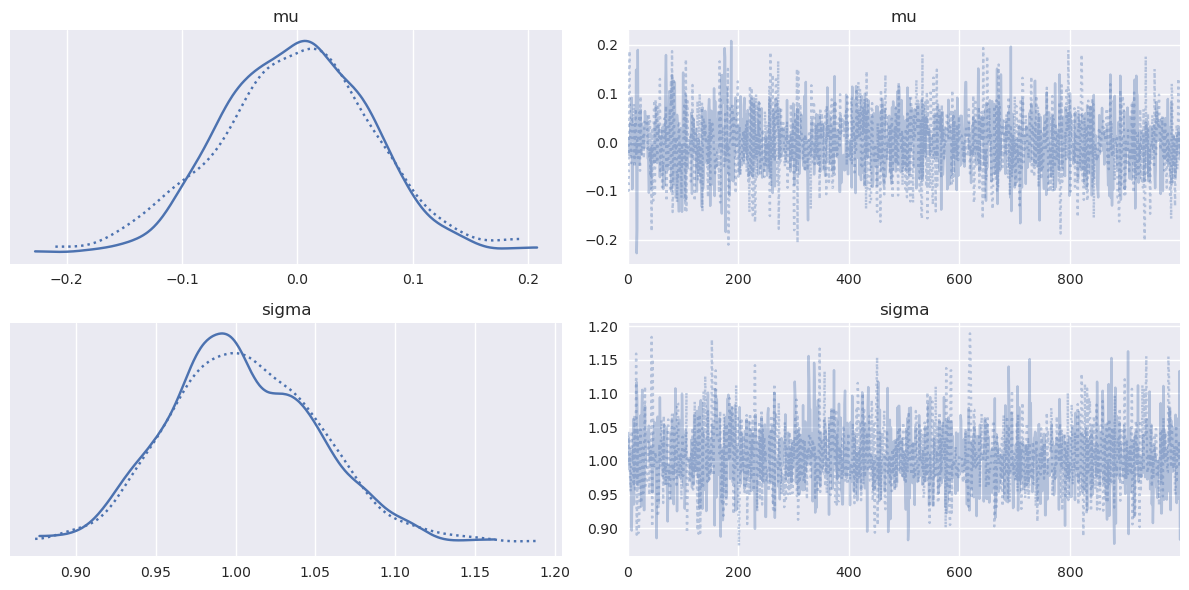


⚠️  **Sampling Diagnostics**:
   • Number of divergences: 0
   • Max tree depth reached: 0 times

⚡ **Energy Diagnostics**:


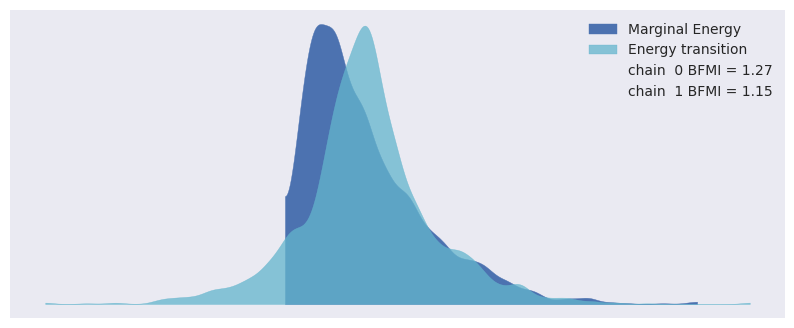


✅ **Diagnostic Interpretation**:
   • R-hat close to 1.0 → Good convergence
   • High ESS → Many effective samples
   • No divergences → Sampling was stable
   • Energy plots overlap → No pathological behavior


In [9]:
# Comprehensive model diagnostics
print("🔧 **Model Diagnostics and Convergence Checking**")
print("="*60)

# Check basic diagnostics
print("\n📊 **Summary Statistics with Diagnostics**:")
summary = az.summary(trace_basic, var_names=['mu', 'sigma'])
print(summary)

# Plot trace plots for visual inspection
print("\n📈 **Trace Plots** (should look like 'fuzzy caterpillars'):")
az.plot_trace(trace_basic, var_names=['mu', 'sigma'], figsize=(12, 6))
plt.tight_layout()
plt.show()

# Check for divergences and other warnings
print("\n⚠️  **Sampling Diagnostics**:")
print(f"   • Number of divergences: {trace_basic.sample_stats.diverging.sum().values}")
print(f"   • Max tree depth reached: {(trace_basic.sample_stats.tree_depth >= 10).sum().values} times")

# Energy plot
print("\n⚡ **Energy Diagnostics**:")
az.plot_energy(trace_basic, figsize=(10, 4))
plt.show()

print("\n✅ **Diagnostic Interpretation**:")
print("   • R-hat close to 1.0 → Good convergence")
print("   • High ESS → Many effective samples")
print("   • No divergences → Sampling was stable")
print("   • Energy plots overlap → No pathological behavior")

## The Complete Bayesian Workflow

Let's summarize the essential steps of Bayesian analysis that we've demonstrated:

### 1. Model Specification
```python
with pm.Model() as model:
    # Priors
    theta = pm.Normal('theta', mu=0, sigma=1)
    # Likelihood  
    obs = pm.Normal('obs', mu=theta, sigma=1, observed=data)
```

### 2. Prior Predictive Checking
```python
prior_pred = pm.sample_prior_predictive(model)
# Check: Do simulated data look reasonable?
```

### 3. Posterior Sampling
```python
trace = pm.sample(model)
```

### 4. Convergence Diagnostics
```python
az.summary(trace)  # Check R-hat, ESS
az.plot_trace(trace)  # Visual inspection
```

### 5. Posterior Predictive Checking
```python
post_pred = pm.sample_posterior_predictive(trace, model)
az.plot_ppc(post_pred)  # Model validation
```

### 6. Inference and Decision Making
```python
# Probability statements
prob_positive = (samples > 0).mean()
# Credible intervals
hdi = az.hdi(samples, hdi_prob=0.95)
```

## Key PyMC Concepts for Time Series

### Important Distributions for Time Series

PyMC provides several distributions specifically designed for time series modeling:

1. **`pm.GaussianRandomWalk`**: For modeling random walk processes
2. **`pm.AR`**: For autoregressive models
3. **`pm.MvGaussianRandomWalk`**: For multivariate random walks
4. **`pm.gp.Marginal`**: For Gaussian process regression

### Model Building Best Practices

1. **Start simple**: Begin with basic models and add complexity gradually
2. **Use informative priors**: Incorporate domain knowledge when possible
3. **Check convergence**: Always examine R-hat and effective sample size
4. **Validate models**: Use posterior predictive checks and cross-validation
5. **Scale your data**: Standardization helps with MCMC convergence

## Summary

In this section, we've covered the essential foundations of Bayesian inference:

### Core Concepts
1. **Statistical paradigms**: Frequentist vs Bayesian worldviews
2. **Bayes' theorem**: The mathematical foundation for learning from data
3. **Prior specification**: Encoding beliefs and domain knowledge
4. **MCMC sampling**: Approximating complex posterior distributions

### Practical Workflow
5. **PyMC API**: Model specification and sampling
6. **Prior predictive checking**: Validating model assumptions
7. **Convergence diagnostics**: Ensuring reliable inference
8. **Posterior predictive checking**: Model validation
9. **Uncertainty quantification**: The key advantage of Bayesian methods

### Time Series Applications
10. **Specialized distributions**: Tools for temporal modeling
11. **Best practices**: Guidelines for robust analysis

**Next**: In Section 3, we'll apply these foundations to build our first time series-specific models using PyMC's specialized distributions.

---

**Key Takeaways**:
- **Bayesian thinking** provides intuitive probability statements about parameters
- **Complete workflow** includes prior/posterior predictive checking and diagnostics
- **PyMC + ArviZ** provide a powerful toolkit for Bayesian time series analysis
- **Model checking** is essential - never trust results without validation
- **Uncertainty quantification** enables better decision-making under uncertainty